## MEAM 5460 Project 1: Blade Element Momentum Theory
### Author: Nathaniel Ruhl
### GitHub: https://github.com/nruhl25/HoveringVehicleDesign/tree/main/proj1

### 1) Introduction

In this report, I expand the BEMT tool first developed in Homework 3. BEMT is a powerful analysis tool because it enables us to accurately model, analyze, and optimize different rotor blade designs without too many assumptions. In this report, we will break some of the assumptions used in [Homework 3](https://github.com/nruhl25/HoveringVehicleDesign/blob/main/hw3/hw3_report.ipynb). We are still considering a rotor in hover, but we consider linear variations of the following rotor properties: rotor twist distribution $\theta(r)$, blade section chord length $c(r)$, and linear airfoil lift-curve slopes $c_{l,\alpha}$. The enumerated list below shows the key factors and models built into the "BEMT2" tool.

1. The rotor is in hover: $\lambda_c = 0$
2. Linear twist distribution, specified by input collective at 75%R and the linear twist rate: $\theta(r) = \theta_{75} + \theta_{tw}(r-0.75)$
3. Linear taper of local blade chord, specified by the chord at 75%R and the taper rate (TR): $c(r) = c_{base}(\frac{1}{TR}-1)r + c_{base}$ where $c_{base} = \frac{c_{75}}{\frac{0.75}{TR}+0.25}$
4. Linear airfoil lift-curve slopes, specified by the slope at 75%R and the airfoil varitation root-to-tip (AV): $c_{l_\alpha}(r)=c_{l_\alpha}^{(75)}+AV(r-0.75)$
5. The Prandtl tip loss factor, $0<F<1$, describes the increase of induced velocity near the rotor tip
6. The code works for a "GENERAL" linear airfoil with section coefficients of drag $c_{d}(\alpha)=c_{d_0}=0.01$, as well as the "NACA0012" with a quadratic fit to $c_{d}(\alpha)$ data.

This list can be directly compared to the enumerated list in my [Homework 3 Report](https://github.com/nruhl25/HoveringVehicleDesign/blob/main/hw3/hw3_report.ipynb) in order to better understand the additions to the update BEMT tool.

### 2) The "Rotor2" class and baseline test rotor specifications

The test rotor specifications that will be considered in this report are used as the default instance properties in the "Rotor2" class. The default properties are

- $N_b$ = 3
- $R$ = 30 ft
- $v_{tip}$ = 780 ft/sec

and the (property) coefficients defining the linear variations are

__Twist distribution__:
- $\theta_{75}=9^\circ$ (I define as the default because the assignment does not specify)
- $\theta_{tw}=-8^\circ$ per non-dimensional radius

__Taper__:
- $c_{75} = 2$ ft
- $TR = 1$ per non-dimensional radius (no taper)

__Airfoil variation__:
- $c_{l,\alpha}^{(75)}=2\pi$
- $AV=0$ per non-dimensional radius


As we will discuss at the end of the report, these are typical values for a Chinook weighing about 40,000 lbf.




### 3) BEMT Equations and the Prandtl Tip Loss Factor

This section builds off the discussion in [Homework 3 Report](https://github.com/nruhl25/HoveringVehicleDesign/blob/main/hw3/hw3_report.ipynb), which can be referenced if additional information is needed regarding the BEMT Equations. Here, we focus on the adition of Prandtl's Tip Loss Function to BEMT. The purpouse of Prandtl's $F$ function is to increase the induced velocity and reduce the lift generated near the tip of a blade, which is an effect associated with a rotor having a finite number of blades. These losses can be captured in the factor $F$:

$$F = \left( \frac{2}{\pi} \right) \cos^{-1}(\exp(-f))$$

where $f$ depends on the number of blades and the non-dimensional radial position, $r$, of the blade element,

$$f = \frac{N_b}{2}\left( \frac{1-r}{r \phi(r)}\right)$$

and $\phi(r)=\lambda(r)/r$ is the induced inflow angle. 

With the addition of the tip loss function, the section (or "local") thrust and induced power coefficients can be written as 

$$c_t(r) = 4 F \lambda(r)^2 r$$
$$c_{p_i}(r) = 4 F \lambda(r)^3 r$$
$$c_{p_0}(r) = \frac{1}{2} \sigma(r) r^3$$

The total coefficients of thrust and induce power can then be determined by the numerical integrals

$$C_T = 4 \int_0^1 \lambda(r)^2 r dr$$
$$C_{P_i} = 4 \int_0^1 \lambda(r)^3 r dr$$
$$C_{P_0} = \frac{1}{2} \sigma_{ave} \int_0^1 c_d(r) r^3 dr$$.

The total rotor power is thus 

$$C_P = C_{P_i}+C_{P_0}$$ 

where the profile part of the power is implemented in two ways. As I did in HW3, if we assume $c_{d}(\alpha)=c_{d,0}$ is constant, then the total profile power is

$$C_{P_0} = \frac{c_{d_0}}{2} \sigma_{ave} \int_0^1 r^3 dr.$$

I have also experimental data for the NACA0012 airfoil in order to see the effects of a profile drag changing as a function of radius along the rotor (since section AoA changes with radius). The plot below shows a quadratic fit of the form 

$$c_{d}(\alpha) = d_0 + d_1 \alpha + d_2 \alpha^2.$$

The fit to the data below is not amazing, but I wanted to implement this model in the BEMT2 software, and it can be adjusted in the future. For $\alpha$ in radians, the fit parameters turn out to be

- $d_0=0.0128$
- $d_1=-0.0751$
- $d_2=0.6808$


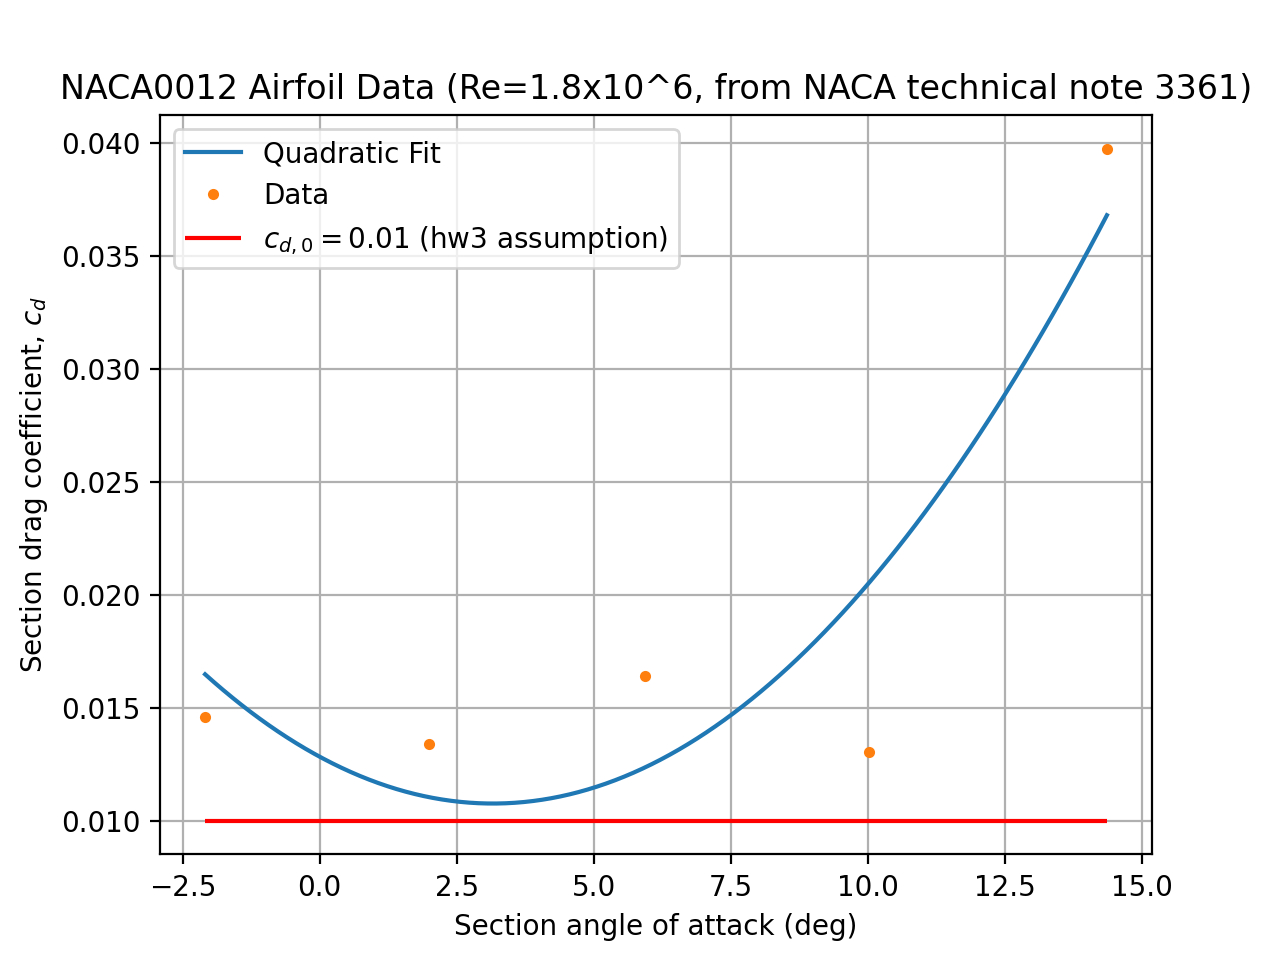

In [123]:
from IPython.display import Image
Image(filename='NACA0012_cd.png',width=600)

### Calculation of Induced Inflow with the Prandtl Tip Loss Function

By equating the local thrust coefficients from momentum and blade element theories, it can be shown that

$$\lambda(r) = \frac{\sigma_{ave} c_{l,\alpha}(r)}{16 F} \left( \sqrt{1+\frac{32 F}{\sigma_{ave} c_{l,\alpha}(r)} \theta(r) r} - 1 \right) $$

where the linear variations of $c_{l,\alpha}(r)$, $\theta(r)$ are given in Section 2, and the solidity $\sigma_{ave}$ is the rotor solidity based on the average chord length:

$$\sigma_{ave} = \frac{N_b c_{ave}}{\pi R}, \quad c_{ave} = 0.5(c(0)+c(1))$$

It should be noted that although $\lambda$ depends explicitly on $F$, $F$ is also a function of $\lambda$. Therefore, $\lambda$ must be calculated iteratively using $F=1$ as a starting point.

### 4) Analysis

This analysis makes use of the modules, classes, and functions imported in the cell block below. It should be noted that I often used upper case greek letters as function definitions and that $c_t(r)=$ `dCT(R)` and $c_{p_i}= $ `dCPi(r)` in the code. The functions also take inputs of a Rotor object and $F$, and you can write `Theta?` in a code cell to see information about the $\theta(r)$ function.

Lastly, the two codebloacks below are all that is needed to use this tool. The `rotor` object can be changed dynamically as the user desires (although it is always good to confirm that you are correctly changing the rotor object in the Kernel memory, and re-run the `importlib.reload()` lines if changes are made to the scripts).

Most of the basic user interface with the `BEMT2` functions can be done through libraries `tools.py` and `plotter.py`, as will be shown in the code below.

In [154]:
# import standard libraries
import importlib
import numpy as np
import matplotlib.pyplot as plt

# import local modules (these scripts must be in the working directory)
import Rotor2  # Rotor2 class definition
import BEMT2   # BEMT2 tool
import tools   # various tools to interface with BEMT2
import plotter  # various plotting tools to shorten code in this report
importlib.reload(BEMT2)
importlib.reload(Rotor2)
importlib.reload(tools)
importlib.reload(plotter)
from Rotor2 import Rotor2

In [163]:
rotor = Rotor2()

### Addition of varying blade section coefficient $c_d(\alpha(r))$ (without tip losses)
Consider the addition of the quadratic section drag coefficient for the baseline test rotor with the following specifications:

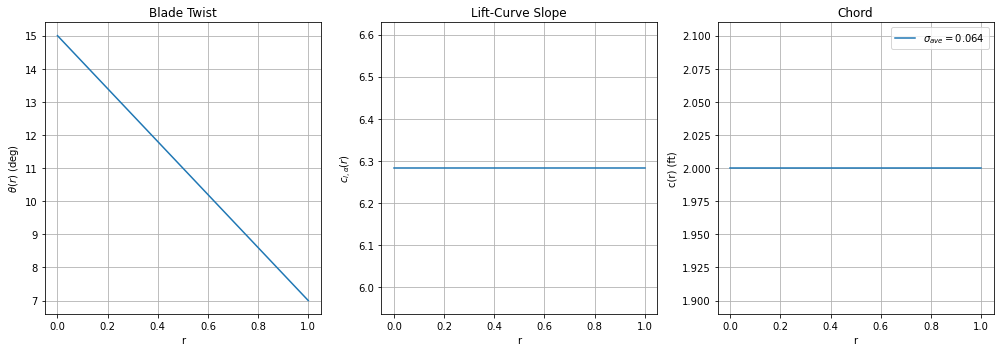

Other rotor2 properties: Nb=3, R=30 ft, vtip = 780 ft/sec


In [164]:
plotter.plot_rotor2(rotor)

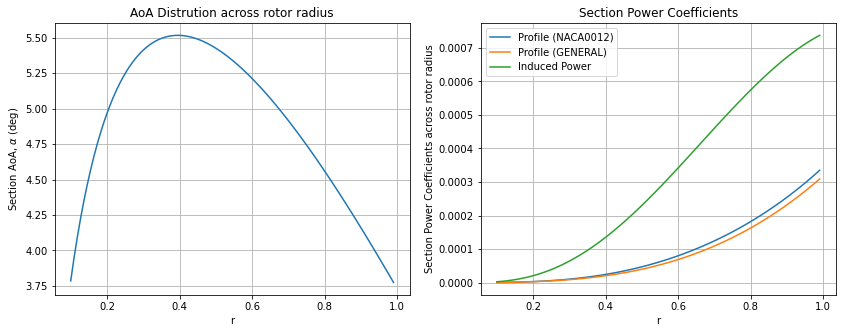

NACA0012 airfoils: Profile contribution to total power = 0.234
GENERAL airfoil: Profile contribution to total power = 0.215


In [165]:
plotter.plot_NACA0012_drag_effects(rotor)

The second plot above with the "section" power coefficients shows the effect of using of a (potentially) more accurate model for the section drag coefficient (NACA0012 vs GENERAL), while the induced power is the same in both cases. We see that the assumption of $c_{d,0}=0.01$ slightly under-estimates the drag and profile power, especially near the blade tips.

### Addition of Prandtl Tip Loss Function

Consider the addition of the Prandtl tip loss factor for the baseline test rotor:

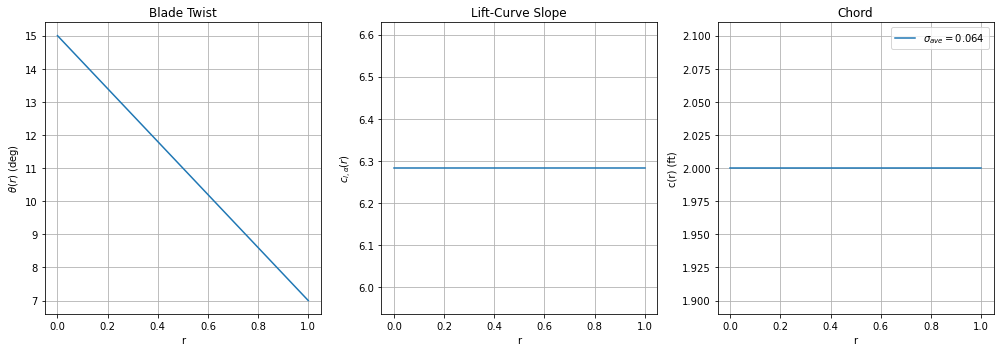

Other rotor2 properties: Nb=3, R=30 ft, vtip = 780 ft/sec


In [166]:
rotor = Rotor2()
plotter.plot_rotor2(rotor)

The plots below match our expectation for the Prandtl tip loss function, as it shows an increase of induced inflow near the tips (caused by blade-tip vortices) and therefore a decrease in thrust and induced power.

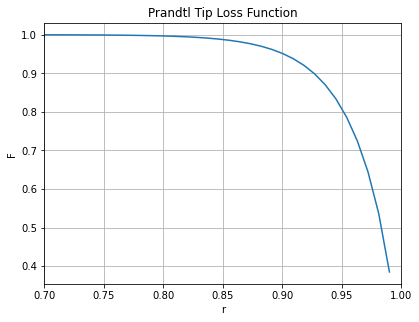

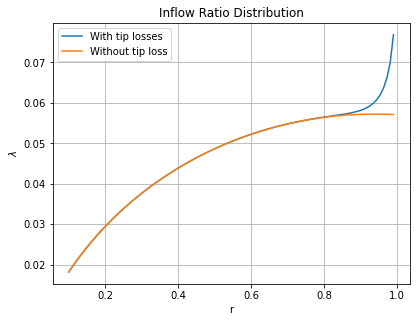

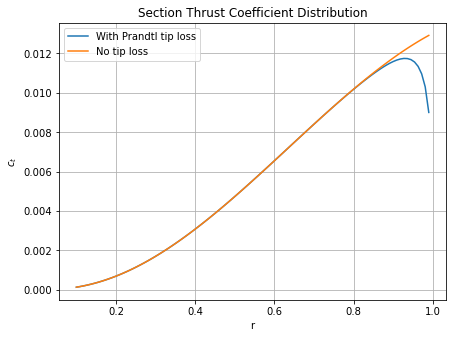

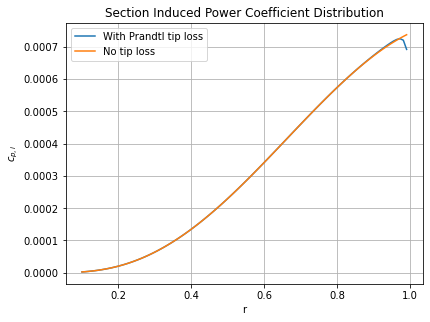

In [168]:
plotter.plot_prandtl_comparison(rotor, airfoil="GENERAL")

### Validation of Test Rotors (1-4)

In order to ascertain whether the tool is giving the correct results, and to demonstrate how to use the functions, we will consider the 4 test rotors given in the project assignment. The changes to the rotor properties identified below alter the default rotor2 definition.

#### Rotor 1: Constant chord of 2 ft with constant airfoil

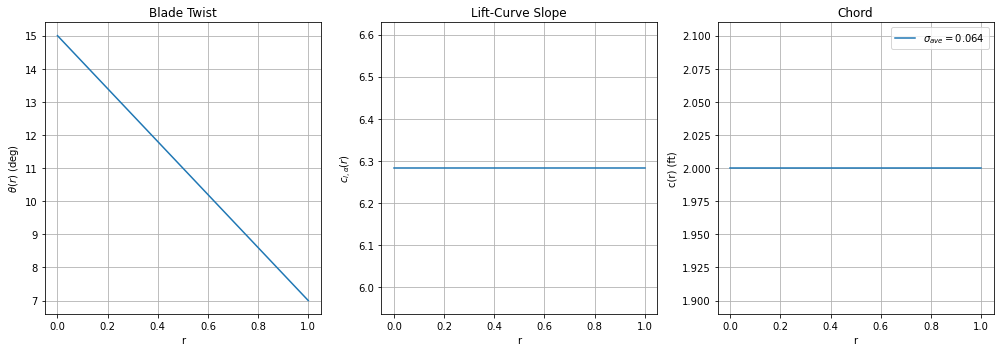

Other rotor2 properties: Nb=3, R=30 ft, vtip = 780 ft/sec


In [169]:
rotor1 = Rotor2()  # Make sure we reset to defaults

rotor1.chord_75 = 2
rotor1.TR = 1

rotor1.cl_slope_75 = 2*np.pi
rotor1.AV = 0

plotter.plot_rotor2(rotor1)

#### Rotor 2: Constant chord of 2 ft with varying airfoils: $c_{l,\alpha}=2\pi$ at root and $c_{l,\alpha}=6.0$ at tip

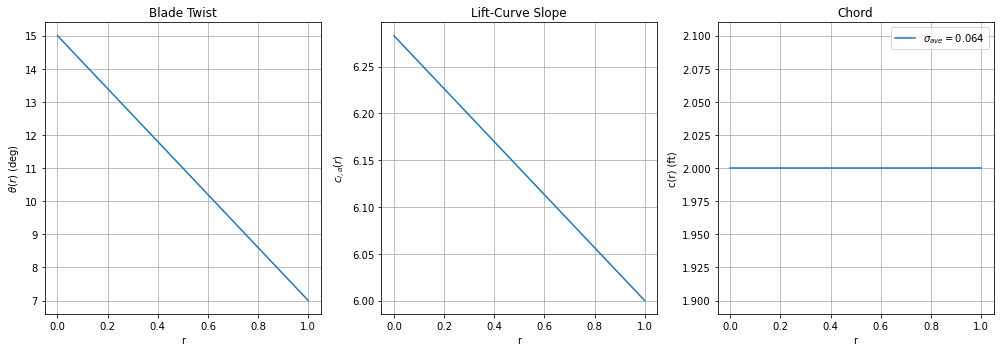

Other rotor2 properties: Nb=3, R=30 ft, vtip = 780 ft/sec


In [170]:
rotor2 = Rotor2()

rotor2.chord_75 = 2
rotor2.TR = 1

rotor2.AV = 6-2*np.pi
rotor2.cl_slope_75 = 2*np.pi+0.75*(6.0-2*np.pi)

plotter.plot_rotor2(rotor2)

#### Rotor 3: 2:1 taper ratio (2ft chord at 75%R) with constant airfoil, $c_{l,\alpha}=2\pi$

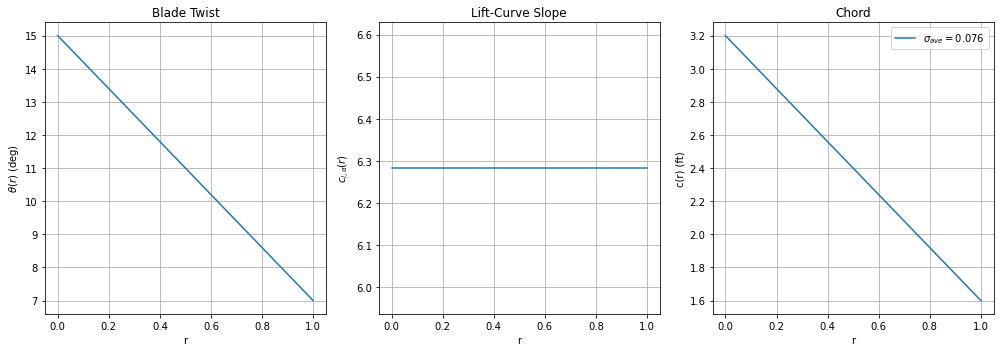

Other rotor2 properties: Nb=3, R=30 ft, vtip = 780 ft/sec


In [171]:
rotor3 = Rotor2()

rotor3.TR = 2
rotor3.chord_75 = 2  # ft

plotter.plot_rotor2(rotor3)

#### Rotor 4: 2:1 taper ratio (2 ft chord at 0.75R) with varying airfoils, $c_{l,\alpha}=2\pi$ at root and $c_{l,\alpha}=6.0$

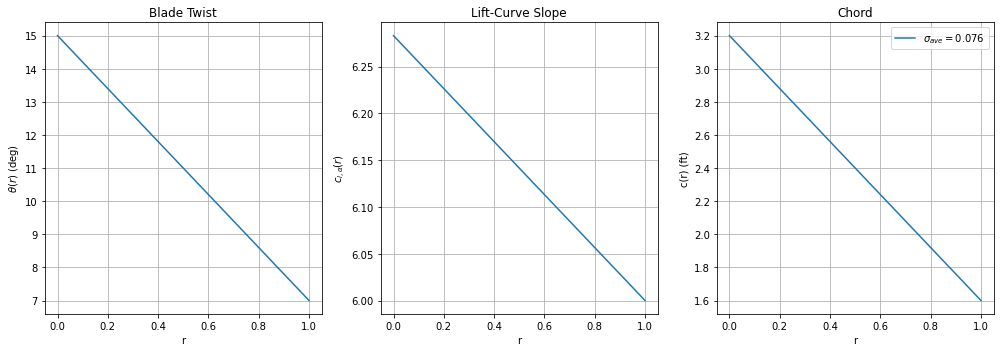

Other rotor2 properties: Nb=3, R=30 ft, vtip = 780 ft/sec


In [172]:
rotor4 = Rotor2()

rotor4.TR = 2
rotor4.chord_75 = 2  # ft

rotor4.AV = 6-2*np.pi
rotor4.cl_slope_75 = 2*np.pi+0.75*(6.0-2*np.pi)

plotter.plot_rotor2(rotor4)

### Comparison of test rotors 1-4

As shown in the plots below, rotors 1/2 and rotors 3/4 exhibit very similar performances. I will provide further analysis below the plots.

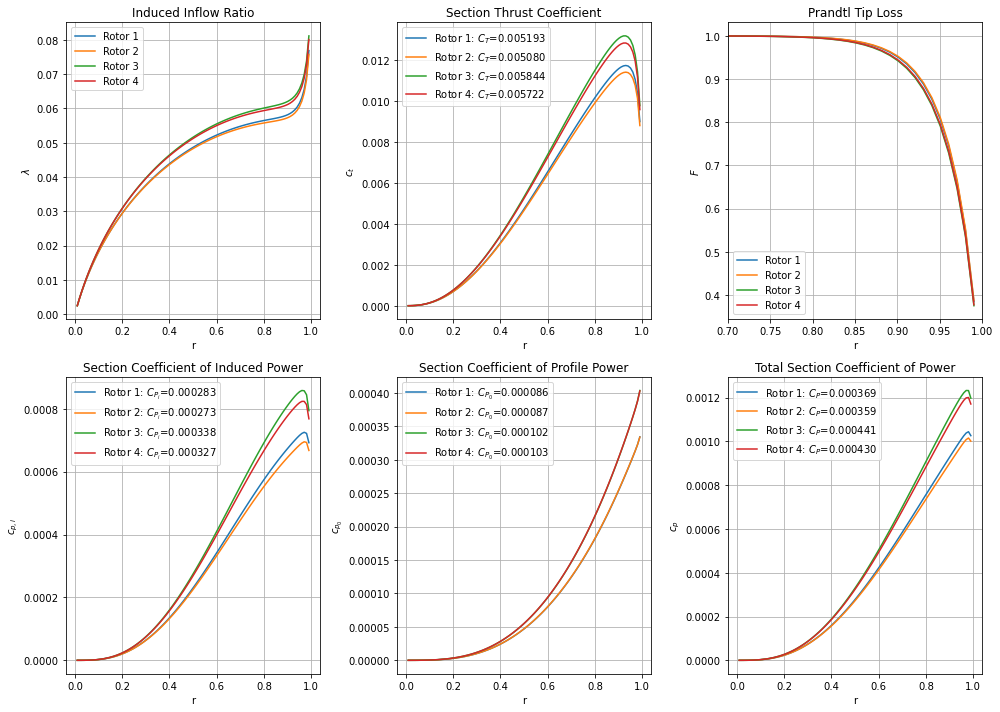

In [173]:
rotor_list = [rotor1, rotor2, rotor3, rotor4]

plotter.compare_rotors(rotor_list)

- The difference between the group of rotors 1/2 (both non-tapered) and the group of rotors 3/4 (both tapered) indicates that taper (_for a constant $c_{75}$_) increases induced inflow/induced power, thrust, and profile power. As As can be seen in the formula for $\lambda(r)$, a larger average solidity leads to more induced inflow, and therefore more thrsut and induced power. The average solodity of the first two rotors is $0.06$ and it is $0.07$ for the second two rotors. Furthermore, the profile drag and power also increase beacause of a larger solidity (surface area).
- The differences between Rotors 1 and 2 and Rotors 3 and 4 is mainly a slight decrease in thrust, which makes sense because the lift-curve slopes of Rotors 2 and 4 decrease along the rotor blade, while they are constant for Rotors 1 and 3, so slightly less lift is generated.
- Rotors 1 and 2 are very slightly better than Rotors 3 and 4 in terms of avoiding tip losses, which is unexpected. As we will see further below, blade taper leads to a decrease in tip losses when everything else is held constant. The unexpected is likely related to the fact the Rotors 3 and 4 start with a chord of 3.2 ft at the base of the rotor (instead of 2 ft). Therefore, there is already more inflow induced at the tips by inboard blade sections, which could mean that the tip loss factor does not have to be as significant in order to capture reality. If this argument is true, it means that BEMT (without tip losses) already captures the induced (interference) effects that Prandtl's Lifting Line Method attempts to capture in the analysis of fixed-wing aerodynamics.
- The plot shows the reduction of local airfoil angle of attack for Rotors 3 and 4, which have larger inflow.

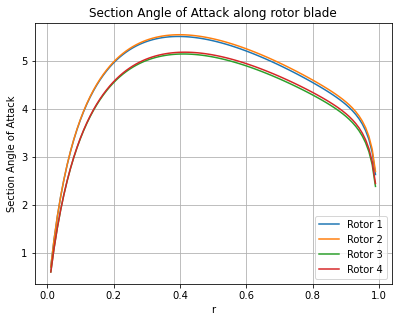

In [174]:
rotor_list = [rotor1, rotor2, rotor3, rotor4]
plotter.compare_aoas(rotor_list)

In the next section, we will confirm some of the observations made above, and also explore a few additional blade properties.

In [175]:
import warnings
warnings.filterwarnings("ignore")

## Effect of Various Blade Design Specs on Performance

In the subsequent analysis, I will vary various blade properties and observe the effects. Note that the function `plotter.vary_propertyX_plot_files()` has the default keyword arguments `airfoil="NACA0012"` and `use_F=True`, which can also be changed to airfoil="GENERAL" and use_F=False. While I only consider a few rotor properties below, the function `plotter.vary_propertyX_plot_files()` can be used in the same way to explore the effect of changing other Rotor2 object properties.

Listed below are the main design choices that we will consider (all for hover):

1) Increasing input collective, $\theta_{75}$, leads to greater thrust generation  
2) Tapering a blade moves reduces tip losses  
3) A larger negative twist $\theta_{tw}$ reduces induced power by moving thrust inboard  
4) We will also consider the effect of changing $\theta_{75}$ and $c_{75}$  

### Varying $\theta_{75}$ 

I first wanted to vary $\theta_{75}$, since we made these plots in Homework 3 for an ideal twist distribution, which had a uniform inflow along the blade span. It is clear that increasing $\theta_{75}$ leads to an increase in total thrust, however the thrust distribution moves closer and closer to the tip, leading to greater tip losses. I mainly included the power ratios printed below to understand the relative size of the different compnents of power, espcially since I only in included the plot of the total section power coefficient.

$\theta_{75}$=3.0$^\circ$: Power ratio: C_Pi/C_P0=0.313, solidity = 0.064
$\theta_{75}$=6.0$^\circ$: Power ratio: C_Pi/C_P0=1.453, solidity = 0.064
$\theta_{75}$=9.0$^\circ$: Power ratio: C_Pi/C_P0=3.272, solidity = 0.064


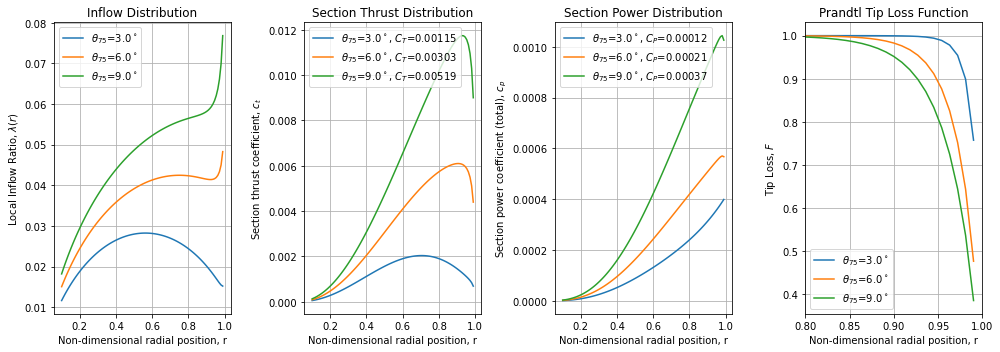

In [157]:
rotor = Rotor2()
theta75_list = np.deg2rad(np.array([3, 6, 9]))
theta75_labels = [fr"$\theta_{{75}}$={np.rad2deg(theta75_list[0]):.1f}$^\circ$", fr"$\theta_{{75}}$={np.rad2deg(theta75_list[1]):.1f}$^\circ$", fr"$\theta_{{75}}$={np.rad2deg(theta75_list[2]):.1f}$^\circ$"]
plotter.vary_propertyX_plot_profiles(rotor, 'theta_75', theta75_list, theta75_labels)

### Varying Taper ratio, TR

The results below show that increasing blade taper reduces tip losses. The power ratios printed out below also stay fairly constant, but this is only possible because of an increase in solidity and profile power.

TR: 1:1: Power ratio: C_Pi/C_P0=3.272, solidity = 0.064
TR: 2:1: Power ratio: C_Pi/C_P0=3.302, solidity = 0.076
TR: 3:1: Power ratio: C_Pi/C_P0=3.304, solidity = 0.085
TR: 4:1: Power ratio: C_Pi/C_P0=3.299, solidity = 0.091


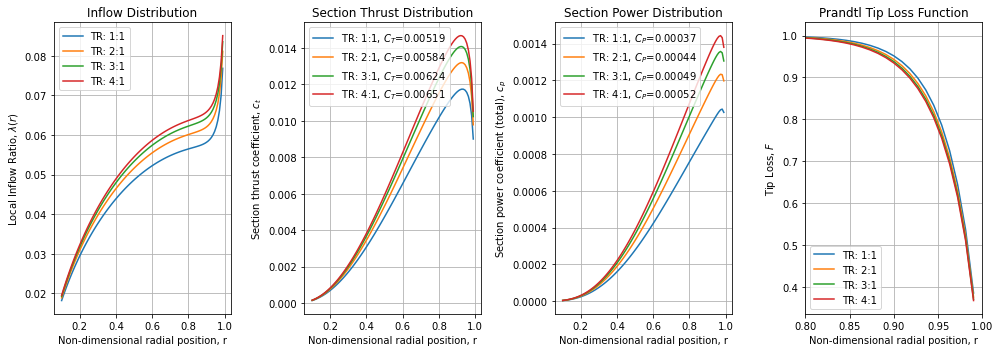

In [158]:
rotor=Rotor2()
TR_list = [1, 2, 3, 4]
TR_labels = ["TR: 1:1", "TR: 2:1", "TR: 3:1", "TR: 4:1"]
plotter.vary_propertyX_plot_profiles(rotor, 'TR', TR_list, TR_labels)

### Varying $\theta_{tw}$

The plots below show that a larger negative blade twist leads to a decrease in tip losses and higher efficiency, resulting from moving inflow and thrust further inboard.

$\theta_{tw}$ = -15.0$^\circ$: Power ratio: C_Pi/C_P0=3.181, solidity = 0.064
$\theta_{tw}$ = -10.0$^\circ$: Power ratio: C_Pi/C_P0=3.241, solidity = 0.064
$\theta_{tw}$ = -5.0$^\circ$: Power ratio: C_Pi/C_P0=3.324, solidity = 0.064
$\theta_{tw}$ = 0.0$^\circ$: Power ratio: C_Pi/C_P0=3.427, solidity = 0.064


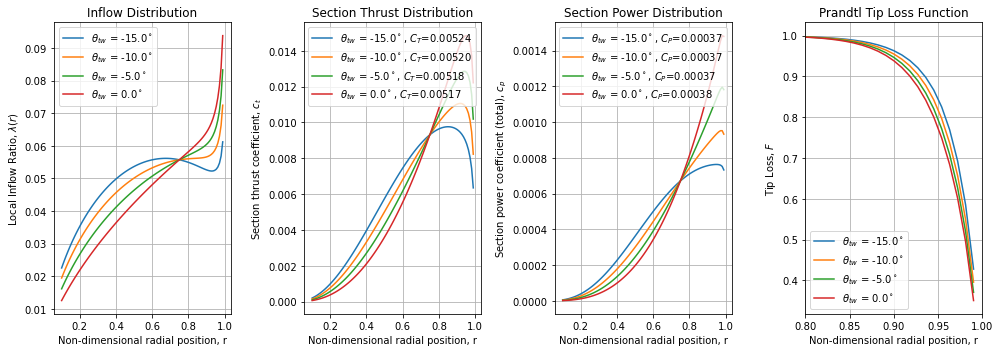

In [159]:
rotor=Rotor2()
theta_tw_list = np.deg2rad(np.array([-15, -10, -5, 0]))
theta_tw_labels = []
for theta_tw in np.rad2deg(theta_tw_list):
    theta_tw_labels.append(fr"$\theta_{{tw}}$ = {theta_tw:.1f}$^\circ$")
plotter.vary_propertyX_plot_profiles(rotor, 'theta_tw', theta_tw_list, theta_tw_labels)

### Varying $c_{75}$

Increasing $c_{75}$ simply leads to greater thrust generation and power, with mostly the same profiles. Tip losses become slightly more important as $c_{75}$ increases. The power ratios printed below show that even though the blade surface area, and therefore drag is increasing, the induced power is increasing at a quicker rate than the profile power.

$c_{75}$=1.5: Power ratio: C_Pi/C_P0=3.160, solidity = 0.048
$c_{75}$=2.0: Power ratio: C_Pi/C_P0=3.272, solidity = 0.064
$c_{75}$=2.5: Power ratio: C_Pi/C_P0=3.305, solidity = 0.080


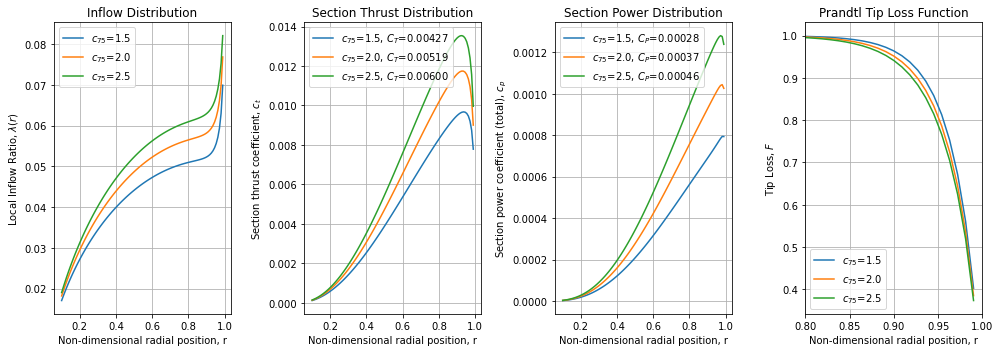

In [160]:
rotor=Rotor2()
c75_list = [1.5, 2.0, 2.5]
c75_labels = [fr"$c_{{75}}$="+str(c75) for c75 in c75_list]
plotter.vary_propertyX_plot_profiles(rotor, 'chord_75', c75_list, c75_labels)

### Understanding coefficient data (badeline test rotor)

In order to get an idea of the size of the total dimensional thrust and power values, let's consider the baseline test rotor. A signle rotor generates ~20,000 lbf of thrust, which is sufficient to lift a two-rotored Chinook weighing 40,000 lbf.

In [161]:
rotor=Rotor2()
CT, CPi, CP0 = tools.calc_CT_CPi_CP0(rotor, airfoil="GENERAL", use_F=True)
CP = CPi+CP0
T = CT*BEMT2.rho0*(np.pi)*(rotor.R**2)*rotor.vtip**2
P = CP*BEMT2.rho0*(np.pi)*rotor.R**2*rotor.vtip**3
P_hp = P*0.0018 # horsepower
print(f"T={T/1000:.7f} *10^3 lbf trhust generation (single rotor)")
print(f"P={P_hp/1000:.7f} *10^3 hP required (single rotor)")

T=21.2417208 *10^3 lbf trhust generation (single rotor)
P=2.0663197 *10^3 hP required (single rotor)


### Convergence Test for Numerical integration

I use a trapezoidal rule with $N=5000$ intervals (default) to integrate the profiles of $c_{p_i}$, $c_{p_0}$, and $c_t$. We must pay careful attention when integrating these profiles, especially near the base and the tip where discontinuities occur. Based on trial and error, I determined that it was suitable to use the approximate integration domain $0.01 < r < 0.99$. The plot below shows that $N=5000$ is suitable to obtain an accuracy of approximately 1e-6 on $C_P$ and $C_T$.

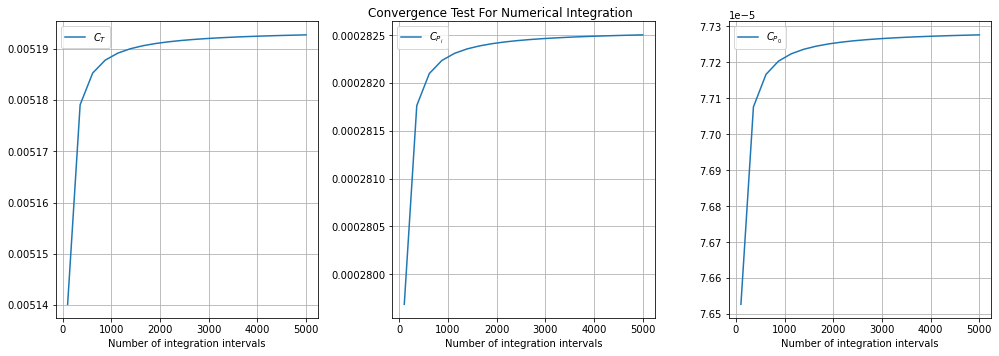

In [162]:
plotter.convergence_test(rotor)